In [60]:
import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

class CancerDetectModel(nn.Module):
    def __init__(self):
        super(CancerDetectModel, self).__init__()
        self.name = "CancerDetectModel"
        self.conv1 = torch.nn.Conv2d(3, 32, 5, 5)
        self.conv2 = torch.nn.Conv2d(32, 64, 3, 1)
        self.conv3 = torch.nn.Conv2d(64, 128, 4, 2)
        self.fc = nn.Linear(3 * 3 * 128, 2)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = F.leaky_relu(self.conv3(x))
        x = x.view(-1, 3 * 3 * 128)
        x = self.fc(x)
        return x

In [61]:
def get_data_loader(batch_size, file_path):
    transform = torchvision.transforms.ToTensor()
    train_dataset = torchvision.datasets.ImageFolder(file_path + \
                                                '/train', transform=transform)
    val_dataset = torchvision.datasets.ImageFolder(file_path + \
                                                '/validation', transform=transform)
    test_dataset = torchvision.datasets.ImageFolder(file_path + \
                                                  '/test', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_dataset, \
                                      batch_size=batch_size, shuffle = True)
    val_loader = torch.utils.data.DataLoader(val_dataset, \
                                      batch_size = batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, \
                                      batch_size = batch_size, shuffle=True)
    
    return train_loader, val_loader, test_loader

In [62]:
filepath = "./breast-histopathology-imagesNEW"
batch_size = 32
train_loader, val_loader, test_loader = get_data_loader(batch_size, filepath)

def train_network(network, train_loader, val_loader, num_epochs = 30, \
                  batch_size = 32, learning_rate = 0.001):
    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(network.parameters(), learning_rate)
    
    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    
    for epoch in range(num_epochs):
        for input, label in iter(train_loader):
            output = network(input)
            loss = criterion(output, label)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
    
        model_path = get_model_name(network.name, batch_size, learning_rate, epoch)
        torch.save(network.state_dict(), model_path)
        train_loss[epoch], train_acc[epoch] = accuracy(network, train_loader, \
                                                   criterion)
        val_loss[epoch], val_acc[epoch] = accuracy(network, val_loader, criterion)

        print("Epoch: {}, Training loss: {}, Training accuracy: {}, \
        Validation loss: {}, Validation accuracy: {}".format(
              epoch, 
              train_loss[epoch], 
              train_acc[epoch], 
              val_loss[epoch], 
              val_acc[epoch]))
        
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)
    
    return model_path, criterion
  
def accuracy(network, loader, criterion):
    correct = 0.
    count = 0.
    loss = 0.
    for input, label in iter(loader):
        output = network(input)
        loss = criterion(output, label)
        result = torch.argmax(output, 1)
        correct += torch.eq(result, label).sum().item()
        loss += loss.item()
        count += len(label)
        
    return (loss / count, correct / count)

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,batch_size,\
                                                   learning_rate,epoch)
    return path

def plot_training_curves(path):
    train_acc = np.loadtxt("{}_train_acc.csv".format(model_path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(model_path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(model_path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(model_path))
    plt.title("Train vs. Validation Loss")
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label = 'Validation')
    plt.legend(loc = 'best')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Train vs. Validation Acc")
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.legend(loc = 'best')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.show()

Epoch: 0, Training loss: 5.412468340182386e-07, Training accuracy: 0.8274525070071629,         Validation loss: 4.290383458283031e-06, Validation accuracy: 0.8263139406712938
Epoch: 1, Training loss: 7.538771114923293e-06, Training accuracy: 0.8608585072147825,         Validation loss: 7.726374860794749e-06, Validation accuracy: 0.8593941155807503
Epoch: 2, Training loss: 4.064154097704886e-07, Training accuracy: 0.8639105159348074,         Validation loss: 1.0867954188142903e-05, Validation accuracy: 0.8623133108034449
Epoch: 3, Training loss: 2.0182631033094367e-06, Training accuracy: 0.867696979134226,         Validation loss: 6.253761057450902e-06, Validation accuracy: 0.8622406337439588
Epoch: 4, Training loss: 6.345622978187748e-07, Training accuracy: 0.8621717014429565,         Validation loss: 4.486983016249724e-06, Validation accuracy: 0.8565960487905326


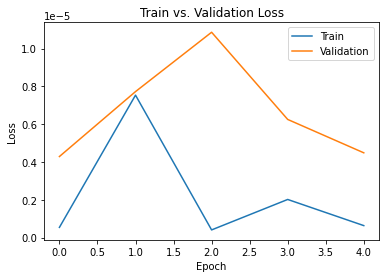

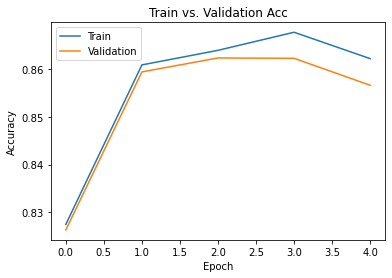

In [38]:
model = CancerDetectModel()
model_path, criterion = train_network(model, train_loader, val_loader num_epochs=5)
plot_training_curves(model_path)

In [40]:
correct = 0.
count = 0.
total = 0
for input, label in iter(val_loader):
    output = model(input)
    loss = criterion(output, label)
    result = torch.argmax(output, 1)
    for i in range(len(label)):
        if label[i] == 1:
            if result[i].item() == 0:
                count += 1
            total += 1
print(count/total)

0.3316125756357636


In [54]:
import torchvision.models
alexnet = torchvision.models.alexnet(pretrained=True)

train_images = []
train_labels = []
resize_transform = torchvision.transforms.Resize(224)

for i, data in enumerate(train_loader.dataset):
    input, label = data
    if i > 1000:
        break
    rescaled_image = resize_transform(input)
    train_images.append(rescaled_image)
    train_labels.append(label)

stacked_images = torch.stack(train_images)
train_feature = alexnet.features(stacked_images)

torch.save(train_feature, "train_features")

In [55]:
val_images = []
val_labels = []

for i, data in enumerate(val_loader.dataset):
    input, label = data
    if i > 300:
        break
    rescaled_image = resize_transform(input)
    val_images.append(rescaled_image)
    val_labels.append(label)

stacked_images = torch.stack(val_images)
val_feature = alexnet.features(stacked_images)

torch.save(val_feature, "val_features")

In [56]:
class SmallCNNandClassifier(nn.Module):
    def __init__(self):
        super(SmallCNNandClassifier, self).__init__()
        self.name = "SmallCNNandClassifier"
        self.conv1 = nn.Conv2d(256, 256, 2, 2)
        self.conv2 = nn.Conv2d(256, 128, 1, 1)
        self.fc1 = nn.Linear(3 * 3 * 128, 2)
    
    def forward(self, x):
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(-1, 3 * 3 * 128)
        x = self.fc1(x)
        return x

Epoch: 0, Training loss: 0.001160808140411973, Training accuracy: 0.9560439560439561,         Validation loss: 0.007627888582646847, Validation accuracy: 0.6938775510204082
Epoch: 1, Training loss: 0.000900065409950912, Training accuracy: 0.965034965034965,         Validation loss: 0.005883781239390373, Validation accuracy: 0.6938775510204082
Epoch: 2, Training loss: 0.00037292888737283647, Training accuracy: 0.973026973026973,         Validation loss: 0.00571177015081048, Validation accuracy: 0.7295918367346939
Epoch: 3, Training loss: 0.00026711414102464914, Training accuracy: 0.978021978021978,         Validation loss: 0.005290883127599955, Validation accuracy: 0.7397959183673469
Epoch: 4, Training loss: 0.00023450587468687445, Training accuracy: 0.98001998001998,         Validation loss: 0.01530283223837614, Validation accuracy: 0.7295918367346939
Epoch: 5, Training loss: 6.987935921642929e-05, Training accuracy: 0.984015984015984,         Validation loss: 0.02412319742143154, Vali

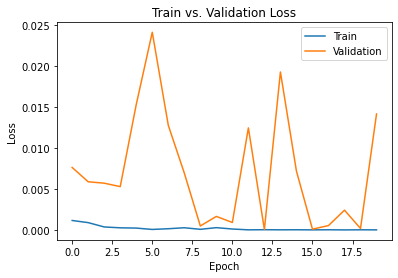

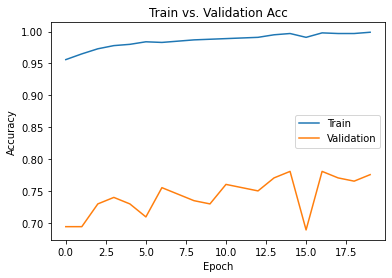

In [57]:
train_features = torch.from_numpy(torch.load("train_features").detach().numpy())
val_features = torch.from_numpy(torch.load("val_features").detach().numpy())

network = SmallCNNandClassifier()

train_labels_tensor = torch.LongTensor(train_labels)
val_labels_tensor = torch.LongTensor(val_labels)

train_set = torch.utils.data.TensorDataset(train_features, train_labels_tensor)
val_set = torch.utils.data.TensorDataset(val_features, val_labels_tensor)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, \
                                           shuffle=True)
val_loader = torch.utils.data.DataLoader(val_set, batch_size=64, shuffle=True)

model_path, criterion = train_network(network, train_loader, val_loader, 20, 64, learning_rate=0.0001)
plot_training_curves(model_path)

In [58]:
class ANN(nn.Module):
    def __init__(self):
        self.name = "ANN"
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(3*50*50, 50)
        self.fc2 = nn.Linear(50, 2)

    def forward(self, x):
        x1 = x.view(-1, 3*50*50)
        x1 = F.relu(self.fc1(x1))
        x1 = self.fc2(x1)
        return x1

Epoch: 0, Training loss: 0.0013064633822068572, Training accuracy: 0.9610894941634242,         Validation loss: 0.007002450525760651, Validation accuracy: 0.7806122448979592
Epoch: 1, Training loss: 0.00117657077498734, Training accuracy: 0.9319066147859922,         Validation loss: 0.00647140946239233, Validation accuracy: 0.7959183673469388
Epoch: 2, Training loss: 0.0010544812539592385, Training accuracy: 0.9552529182879378,         Validation loss: 0.007440360262989998, Validation accuracy: 0.7551020408163265
Epoch: 3, Training loss: 0.0006942562176845968, Training accuracy: 0.9377431906614786,         Validation loss: 0.0034664783161133528, Validation accuracy: 0.7959183673469388
Epoch: 4, Training loss: 0.0004560530069284141, Training accuracy: 0.938715953307393,         Validation loss: 0.004523961339145899, Validation accuracy: 0.7908163265306123
Epoch: 5, Training loss: 0.0003609999839682132, Training accuracy: 0.938715953307393,         Validation loss: 0.0062780557200312614,

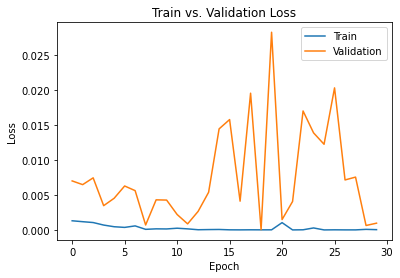

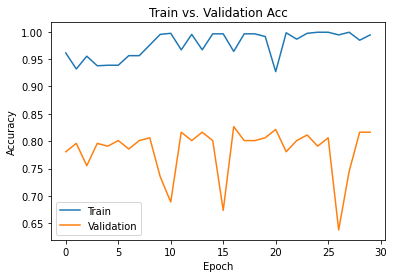

In [63]:
model = ANN()
model_path, criterion = train_network(model, train_loader, val_loader, num_epochs=30)
plot_training_curves(model_path)

In [ ]:
loss, accuracy = accuracy(model, test_loader, criterion) #final test
print("Test accuracy: {}".format(accuracy))